# 1D Burgers Data-Driven Parameter Discovery Numerical

*2024-04-21*

This work is based on:

* *STLSQ* - Sequentially thresholded least squares regression algorithm. Attempts to minimize the objective function by iteratively performing least squares and masking out elements of the weight that are below a given threshold.
* *PySINDy* - [Sparse regression package](<https://pysindy.readthedocs.io/en/latest/examples/10_PDEFIND_examples/example.html#Test-PDE-functionality-on-Burgers'-equation>) with several implementations for the Sparse Identification of Nonlinear Dynamical systems (SINDy) method introduced in Brunton et al. (2016)

In [62]:
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pysindy as ps
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
import warnings
import numpy as np
# Seed for reproducibility
np.random.seed(1000)
# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)

The "burgers_shock.mat" dataset is the same as that used by Raissi et al. (2019):

In [63]:
# Load data from .mat file
data = loadmat('data/burgers_shock.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

Show the dataset:

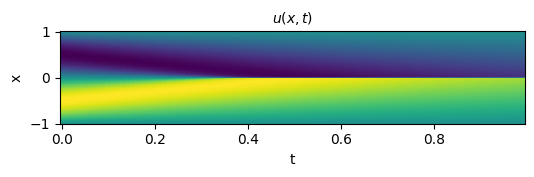

In [64]:
# Plot u
plt.figure(figsize=(6, 1.2))
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=10)
plt.ylabel('x', fontsize=10)
plt.title(r'$u(x, t)$', fontsize=10)
plt.show()

### Solve the equation (inverse problem)

In [65]:
u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

In [68]:
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print("Correct PDE: (u)' = 0.003183 u_11 - uu_1")
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Correct PDE: (u)' = 0.003183 u_11 - uu_1
Identified PDE using the STLSQ model: 
(u)' = 0.00395 u_11 + -1.00833 uu_1 + 0.00126 uuu_11


The original equation is $u_t = 0.1 u_{xx} - uu_x$, meaning:

$\displaystyle \frac{\partial u}{\partial t} = 0.1 \frac{\partial^2u}{\partial x^2} - u \frac{\partial u}{\partial x}$

The original Burgers equation is

$$
\displaystyle \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}
$$

for -1.0 < $x$ < +1.0

and $t$ > 0

Initial conditions are $u(x, 0) = - \sin(\pi x)$

Boundary conditions are $u(-1, t) = u(+1, t) = 0$

The viscosity parameter $\nu$ is taken to be $\frac{0.01}{\pi} = 0.003183$

The differential operator parameter $\lambda_1$ (or $u$) is the speed of fluid at the indicated spatial and temporal coordinates, the differential operator parameter $\lambda_2$ (or $\nu$) is the kinematic viscosity of fluid, and the subscripts denote partial differentiation in time and space, respectively, as
$u_t$ (which denotes $\frac{du}{dt}$), 
$u_x$ (which denotes $\frac{du}{dx}$), and 
$u_{xx}$ (which denotes $\frac{d^2u}{dx^2}$).

## References

Brunton, S. L., Proctor, J. L., & Kutz, J. N. (2016). Discovering governing equations from data by sparse identification of nonlinear dynamical systems. Proceedings of the National Academy of Sciences, 113(15), 3932–3937. https://doi.org/10.1073/pnas.1517384113

Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045
